# VGG-16 (2014) with tf.keras

# Overview
VGG architecture, based on their paper (<a>https://arxiv.org/abs/1409.1556</a>). Tf keras used in this implemention.

The folks at Visual Geometry Group (VGG) invented the VGG-16 which has 13 convolutional and 3 fully-connected layers, carrying with them the ReLU tradition from AlexNet. This network stacks more layers onto AlexNet, and use smaller size filters (2×2 and 3×3). It consists of 138M parameters and takes up about 500MB of storage space 😱. They also designed a deeper variant, VGG-19.

VGG Net is a plain and straight forward CNN architecture among all other. Thought it looks simple, it do outperform many complex architectures. It is the 1st runner-up in ImageNet Challenge in 2014. As shown below, there are totally 6 VGGNet Architectures. Among them, VGG-16 and VGG-19 are popular.

<img src="https://miro.medium.com/max/2244/1*_1DEx3bHlnBApCWWQ0HgcQ.png" alt="Architecture" style="width: 700px; float:center"/>


The idea of VGG architectures is quite simple. we have to stack the convolutional layers with increasing filter sizes. i.e., if layer-1 has 16 filters, then layer-2 must have 16 or more filters.
Another noteworthy point is that in every VGG architecture, all filters are of size 3*3. The idea here is that, two 3*3 filters almost cover the are of what a 5*5 filter would cover and also two 3*3 filters are cheaper than one 5*5 filter(cheaper in the sense of total no. of multiplications to be performed).

The problem with VGG is that this naive architecture is not good for deeper networks, as the deeper the network goes, it is more prone to Vanishing Gradients Problem. More training and also more parameters have to be tuned in deeper VGG architectures.

Lets create a custom VGG Net with 6 convolutional layers in Keras.

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.datasets import fashion_mnist as mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [3]:
num_cores = 4
num_GPU = 1
num_CPU = 1
config = tf.ConfigProto(
    intra_op_parallelism_threads=num_cores,
    inter_op_parallelism_threads=num_cores, 
    allow_soft_placement=True,
    device_count = {
        'CPU' : num_CPU,
        'GPU' : num_GPU
    }
)
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

# Download Data Set & Normalize


!wget --no-check-certificate \
   https://github.com/ck196/tensorflow-alexnet/blob/master/17flowers.tar.gz?raw=true \
    -O ../datasets/17flowers.tar.gz

In [4]:
import tarfile

local_tar = '../datasets/17flowers.tar.gz'
tar = tarfile.open(local_tar, "r:gz")
tar.extractall('../datasets/')
tar.close()

In [5]:
def load_image(path):
    img = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(img)
    return img

In [6]:
PATH = '../datasets/17flowers/jpg'
labels = [label for label in os.listdir(PATH) if os.path.isdir(os.path.join(PATH,label))]
print(f'LABELS: {labels}')
x_train = []
y_train = []
for label in labels:
    path = os.path.join(PATH,label)
    files = os.listdir(path)
    for file in files:
        x_train.append(load_image(os.path.join(path,file)))
        y_train.append(label)
        
x_train = np.array(x_train).astype('uint8')
y_train = np.array(y_train).astype('uint8')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

LABELS: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']
(1088, 224, 224, 3)
(1088,)
(272, 224, 224, 3)
(272,)


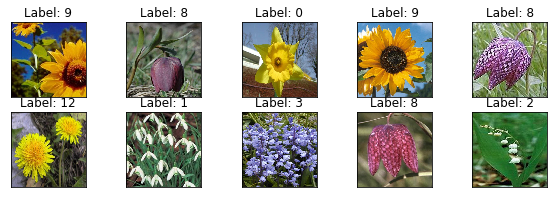

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i in range(10):
  index=i*100
  img = np.reshape(x_train[index],(224,224,3))
  img = img.astype('uint8')
  plt.subplot(5,5,i+1).set_title(f'Label: {y_train[index]}')
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

In [15]:
# To prevent overfitting , ImageDataGenerator used to re-generate images with new scale.
batch_size = 128
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# for test data generator just uses rescale
validation_image_generator = ImageDataGenerator(
    rescale = 1./255
)

train_gen = train_image_generator.flow(x_train, y_train, batch_size=batch_size)
validation_gen = validation_image_generator.flow(x_test, y_test, batch_size=batch_size)

# VGG-16 Architecture
<img src="https://engmrk.com/wp-content/uploads/2018/10/VGG16_Summary-Table.jpg" alt="Architecture" style="width: 600px; float:center"/>

In [16]:
model = tf.keras.models.Sequential([
    Conv2D(64, (3,3), strides=(1,1), padding='same', input_shape=(224,224,3), activation='relu'),
    Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),    
    MaxPooling2D(2,2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(17, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 56, 56, 256)       295168    
__________

In [17]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_gen,
                              steps_per_epoch=len(x_train) / batch_size,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=len(x_test) / batch_size)

    model.evaluate(x_test, y_test)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_4/Adam/mul_123}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_2/dense_8_loss/broadcast_weights/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
## Visualize the Training Process
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training and validation loss')
plt.legend()

plt.show()

# Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
layers = [layer for layer in model.layers[1:]]
vis_model = tf,keras.models.Model(inputs=model.input, outputs=layers)

